In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN as dbs
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


pd.set_option('display.max_columns',None)
data = pd.read_csv('/mnt/NFS_SQUAD_HISTO/OCI_DATA/02_intermediate/preprocessed_oss_counter_all_v3_new.csv',delimiter ='|')
data = data.sort_values(by=['week_period'])
data = data.drop('Unnamed: 0', axis =1)
def process_cell_name(cell):
    return cell.replace("_dismantled","")
data['processed_cell_name'] = data.cell_name.apply(process_cell_name)
to_delete = data[data.duplicated(subset=['processed_cell_name','date'])].sort_values(['date','processed_cell_name'])
cleaned_data = data.drop(to_delete.index)

In [2]:
data = cleaned_data.drop([# ids
                          'index','year','week','week_period','processed_cell_name',
                          # empty
                          'average_number_of_users_dl','average_number_of_users_ul',
                          'cell_occupation_ul_percentage',
                          # highly correlated 
                          'lost_traffic_kerlands',
                          'total_data_traffic_ul_gb'],axis=1)
data

,cell_name,date,cell_band,cell_tech,cell_sector,site_id,total_data_traffic_dl_gb,total_voice_traffic_kerlands,average_throughput_user_dl_kbps,average_throughput_user_ul_kbps,cell_occupation_dl_percentage,traffic_loss_rate,average_number_of_users_in_queue
2357262,OCI1528_DED_L26-1,2020-02-10,L26,4G,1,OCI1528,195.104622,0.00,NaN,NaN,17.16,NaN,NaN
1400808,OCI0274_CAMPEMENT_G18-1,2020-02-10,G18,2G,1,OCI0274,2.877000,2916.24,39.04,22.08,27.04,NaN,NaN
1995627,OCI1014_SOROBANGO_U9-3,2020-02-10,U9,3G,3,OCI1014,26.250000,64.88,4504.88,401.00,81.87,NaN,NaN
2470972,OCI1715_HOTEL_IVOIRE_PALMIER_L26-1,2020-02-10,L26,4G,1,OCI1715,138.929640,0.00,NaN,NaN,15.91,NaN,NaN
1400858,OCI0274_CAMPEMENT_G18-2,2020-02-10,G18,2G,2,OCI0274,7.017000,2619.66,35.27,21.67,30.19,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132188,OCI0307_CNTIG_U21-22,2021-07-19,U21,3G,2,OCI0307,0.000000,0.00,NaN,NaN,NaN,0.0,1.0
905754,OCI2275_MAHINO_U9-2,2021-07-19,U9,3G,2,OCI2275,0.000000,0.00,NaN,NaN,NaN,0.0,2.0
832027,OCI2124_BABA_U9-2,2021-07-19,U9,3G,2,OCI2124,0.000000,0.00,NaN,NaN,NaN,0.0,1.0
564354,OCI1410_ADJAME_MOSQUEE_U21-22,2021-07-19,U21,3G,2,OCI1410,0.000000,0.00,NaN,NaN,NaN,0.0,1.0


In [3]:
dummed_data = pd.get_dummies(data,columns=['cell_band','cell_tech','cell_sector'])
dummed_data

,cell_name,date,site_id,total_data_traffic_dl_gb,total_voice_traffic_kerlands,average_throughput_user_dl_kbps,average_throughput_user_ul_kbps,cell_occupation_dl_percentage,traffic_loss_rate,average_number_of_users_in_queue,cell_band_G18,cell_band_G9,cell_band_L18,cell_band_L23,cell_band_L26,cell_band_L8,cell_band_U21,cell_band_U9,cell_tech_2G,cell_tech_3G,cell_tech_4G,cell_sector_1,cell_sector_2,cell_sector_3,cell_sector_4
2357262,OCI1528_DED_L26-1,2020-02-10,OCI1528,195.104622,0.00,NaN,NaN,17.16,NaN,NaN,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
1400808,OCI0274_CAMPEMENT_G18-1,2020-02-10,OCI0274,2.877000,2916.24,39.04,22.08,27.04,NaN,NaN,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1995627,OCI1014_SOROBANGO_U9-3,2020-02-10,OCI1014,26.250000,64.88,4504.88,401.00,81.87,NaN,NaN,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
2470972,OCI1715_HOTEL_IVOIRE_PALMIER_L26-1,2020-02-10,OCI1715,138.929640,0.00,NaN,NaN,15.91,NaN,NaN,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
1400858,OCI0274_CAMPEMENT_G18-2,2020-02-10,OCI0274,7.017000,2619.66,35.27,21.67,30.19,NaN,NaN,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132188,OCI0307_CNTIG_U21-22,2021-07-19,OCI0307,0.000000,0.00,NaN,NaN,NaN,0.0,1.0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
905754,OCI2275_MAHINO_U9-2,2021-07-19,OCI2275,0.000000,0.00,NaN,NaN,NaN,0.0,2.0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
832027,OCI2124_BABA_U9-2,2021-07-19,OCI2124,0.000000,0.00,NaN,NaN,NaN,0.0,1.0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
564354,OCI1410_ADJAME_MOSQUEE_U21-22,2021-07-19,OCI1410,0.000000,0.00,NaN,NaN,NaN,0.0,1.0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0


In [4]:
data_per_site = dummed_data.groupby(['site_id'],as_index=False)\
                            .agg({'cell_name':'nunique',
                                'total_data_traffic_dl_gb':'mean',
                                'total_voice_traffic_kerlands':'mean',
                                'average_throughput_user_dl_kbps':'mean',
                                'average_throughput_user_ul_kbps':'mean',
                                'cell_occupation_dl_percentage':'mean',
                                'traffic_loss_rate':'mean',
                                'average_number_of_users_in_queue':'mean',
                                'cell_band_G18':'mean',
                                'cell_band_G9':'mean',
                                'cell_band_L18':'mean',
                                'cell_band_L23':'mean',
                                'cell_band_L26':'mean',
                                'cell_band_L8':'mean',
                                'cell_band_U21':'mean',
                                'cell_band_U9':'mean',
                                'cell_tech_2G':'mean',
                                'cell_tech_3G':'mean',
                                'cell_tech_4G':'mean',
                                'cell_sector_1':'mean',
                                'cell_sector_2':'mean',
                                'cell_sector_3':'mean',
                                'cell_sector_4':'mean'})
data_per_site

,site_id,cell_name,total_data_traffic_dl_gb,total_voice_traffic_kerlands,average_throughput_user_dl_kbps,average_throughput_user_ul_kbps,cell_occupation_dl_percentage,traffic_loss_rate,average_number_of_users_in_queue,cell_band_G18,cell_band_G9,cell_band_L18,cell_band_L23,cell_band_L26,cell_band_L8,cell_band_U21,cell_band_U9,cell_tech_2G,cell_tech_3G,cell_tech_4G,cell_sector_1,cell_sector_2,cell_sector_3,cell_sector_4
0,OCI0001,24,114.116414,644.927030,3131.330041,341.242209,62.799111,1.122082e-02,2.122783,0.129758,0.129758,0.0,0.000000,0.084775,0.129758,0.394464,0.131488,0.259516,0.525952,0.214533,0.333333,0.333333,0.333333,0.0
1,OCI0002,24,151.177473,272.318670,4660.582606,514.256532,60.100033,3.002296e-04,1.434615,0.124172,0.124172,0.0,0.000000,0.124172,0.124172,0.377483,0.125828,0.248344,0.503311,0.248344,0.333333,0.333333,0.333333,0.0
2,OCI0003,18,59.256112,346.387819,1369.919444,177.257104,64.389467,0.000000e+00,1.884009,0.165198,0.165198,0.0,0.000000,0.000000,0.000000,0.502203,0.167401,0.330396,0.669604,0.000000,0.333333,0.333333,0.333333,0.0
3,OCI0004,30,204.122368,709.200833,5627.255492,1189.088802,58.689208,9.432792e-04,2.124090,0.103022,0.103022,0.0,0.170330,0.103022,0.103022,0.313187,0.104396,0.206044,0.417582,0.376374,0.378205,0.310897,0.310897,0.0
4,OCI0005,27,177.973410,614.560932,5539.953317,1123.554797,56.473018,3.701701e-03,1.570504,0.121163,0.121163,0.0,0.121163,0.116317,0.116317,0.368336,0.035541,0.242326,0.403877,0.353796,0.333333,0.333333,0.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767,OCI3269,4,0.386635,9.742788,2716.143000,480.366667,56.783437,0.000000e+00,1.058824,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.500000,0.500000,0.000000,0.0
2768,OCI3270,12,10.349527,101.124402,4759.554550,513.085360,24.869221,8.955075e-05,0.566000,0.256410,0.256410,0.0,0.000000,0.000000,0.217949,0.000000,0.269231,0.512821,0.269231,0.217949,0.333333,0.333333,0.333333,0.0
2769,OCI3271,12,37.835383,488.364805,680.782917,73.817857,35.922368,7.277420e-04,1.137255,0.259740,0.259740,0.0,0.000000,0.000000,0.207792,0.000000,0.272727,0.519481,0.272727,0.207792,0.333333,0.333333,0.333333,0.0
2770,OCI3279,12,9.889395,88.031042,1955.041667,208.850714,20.530238,9.307347e-07,0.632381,0.250000,0.250000,0.0,0.000000,0.000000,0.187500,0.000000,0.312500,0.500000,0.312500,0.187500,0.333333,0.333333,0.333333,0.0


In [5]:
scaler = MinMaxScaler()
cols = data_per_site.drop('site_id',axis=1).columns
df_scaled = data_per_site.copy()
for col in cols :
    df_scaled[[col]] = scaler.fit_transform(data_per_site[[col]])
df_scaled
df_final = df_scaled.fillna(df_scaled.mean())
df_final

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys


,site_id,cell_name,total_data_traffic_dl_gb,total_voice_traffic_kerlands,average_throughput_user_dl_kbps,average_throughput_user_ul_kbps,cell_occupation_dl_percentage,traffic_loss_rate,average_number_of_users_in_queue,cell_band_G18,cell_band_G9,cell_band_L18,cell_band_L23,cell_band_L26,cell_band_L8,cell_band_U21,cell_band_U9,cell_tech_2G,cell_tech_3G,cell_tech_4G,cell_sector_1,cell_sector_2,cell_sector_3,cell_sector_4
0,OCI0001,0.383333,0.134026,0.212093,0.074429,0.048350,0.713996,0.996582,0.113602,0.129758,0.129758,0.0,0.000000,0.084775,0.129758,0.394464,0.251022,0.259516,0.525952,0.214533,0.201407,0.462963,0.833887,0.0
1,OCI0002,0.383333,0.177553,0.089555,0.110778,0.072864,0.683308,0.996260,0.076589,0.124172,0.124172,0.0,0.000000,0.124172,0.124172,0.377483,0.240217,0.248344,0.503311,0.248344,0.201407,0.462963,0.833887,0.0
2,OCI0003,0.283333,0.069594,0.113914,0.032562,0.025115,0.732077,0.996251,0.100759,0.165198,0.165198,0.0,0.000000,0.000000,0.000000,0.502203,0.319584,0.330396,0.669604,0.000000,0.201407,0.462963,0.833887,0.0
3,OCI0004,0.483333,0.239735,0.233230,0.133755,0.168479,0.667268,0.996279,0.113672,0.103022,0.103022,0.0,0.702434,0.103022,0.103022,0.313187,0.199301,0.206044,0.417582,0.376374,0.255159,0.431802,0.777760,0.0
4,OCI0005,0.433333,0.209024,0.202106,0.131680,0.159193,0.642071,0.996360,0.083898,0.121163,0.121163,0.0,0.499673,0.116317,0.116317,0.368336,0.067851,0.242326,0.403877,0.353796,0.201407,0.462963,0.833887,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767,OCI3269,0.050000,0.000454,0.003204,0.064561,0.068062,0.645600,0.996251,0.056378,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.401055,0.694444,0.000000,0.0
2768,OCI3270,0.183333,0.012155,0.033256,0.113131,0.072698,0.282751,0.996254,0.029872,0.256410,0.256410,0.0,0.000000,0.000000,0.217949,0.000000,0.513986,0.512821,0.269231,0.217949,0.201407,0.462963,0.833887,0.0
2769,OCI3271,0.183333,0.044436,0.160605,0.016182,0.010459,0.408420,0.996273,0.060596,0.259740,0.259740,0.0,0.000000,0.000000,0.207792,0.000000,0.520661,0.519481,0.272727,0.207792,0.201407,0.462963,0.833887,0.0
2770,OCI3279,0.183333,0.011615,0.028950,0.046470,0.029591,0.233419,0.996251,0.033442,0.250000,0.250000,0.0,0.000000,0.000000,0.187500,0.000000,0.596591,0.500000,0.312500,0.187500,0.201407,0.462963,0.833887,0.0


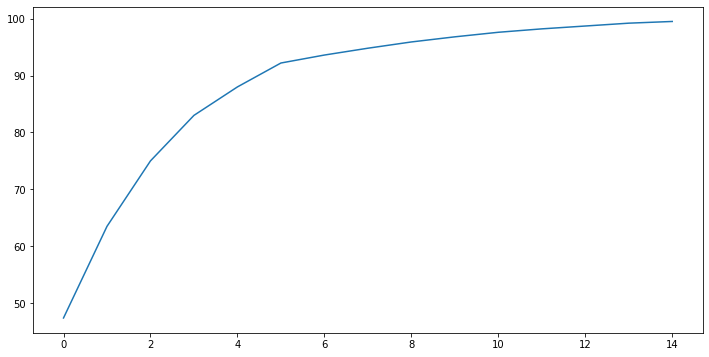

In [10]:
pca = PCA(n_components = 15)
pca.fit(df_final.drop('site_id',axis=1))
variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(variance,3)*100)
plt.figure(figsize=(12,6))
plt.plot(var)
plt.show()

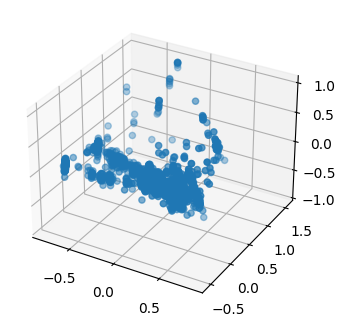

In [11]:
pca_scale = pca.transform(df_final.drop('site_id',axis=1))
pca_df = pd.DataFrame(pca_scale,columns=['pc'+str(i+1) for i in range(15)])

fig = plt.figure(dpi=100)
ax = plt.axes(projection='3d')
x = pca_df.pc1
y = pca_df.pc2
z = pca_df.pc3
ax.scatter3D(x,y,z)
plt.show()

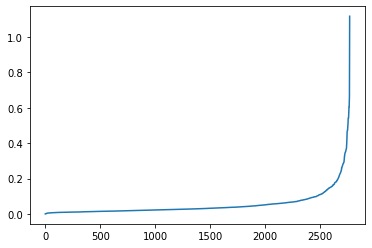

In [12]:
neigh = NearestNeighbors(n_neighbors=2)
nbr = neigh.fit(pca_df)
distances,indexes = nbr.kneighbors(pca_df)
distances = np.sort(distances,axis=0)[:,1]
plt.plot(distances)
plt.show()

In [13]:
pca = PCA(n_components = 7)
pca_scale = pca.fit_transform(df_final.drop('site_id',axis=1))
pca_df = pd.DataFrame(pca_scale,columns=['pc'+str(i+1) for i in range(7)])
res = []
for eps in [.05,.1,.15,.2,.25,.3,.35,.4]:
    for minpts in [2,3]:
        clustering = dbs(eps=eps, min_samples=minpts).fit(pca_df) 
        pca_score = silhouette_score(pca_df,clustering.labels_)
        raw_score = silhouette_score(df_final.drop('site_id',axis=1),clustering.labels_)
        res.append([eps,minpts,len(set(clustering.labels_)),len([i for i in clustering.labels_ if i == -1]),
                    pca_score,raw_score])
        
        
pd.DataFrame(res,columns=['eps','minpts','no_of_clusters','no_of_noise','pca_score','raw_score'])

,eps,minpts,no_of_clusters,no_of_noise,pca_score,raw_score
0,0.05,2,127,428,-0.042521,-0.031177
1,0.05,3,74,534,0.025787,0.057269
2,0.10,2,68,192,-0.007425,0.032660
3,0.10,3,44,240,0.086041,0.087537
4,0.15,2,29,102,0.193706,0.187997
5,0.15,3,21,118,0.249939,0.241819
6,0.20,2,23,61,-0.102992,-0.070766
7,0.20,3,15,77,-0.083613,-0.059760
8,0.25,2,14,38,0.223289,0.331722
9,0.25,3,9,48,0.330367,0.415523


In [17]:
df_to_cluster = df_final.drop('site_id',axis=1)
res = []
for eps in [.05,.1,.15,.2,.25,.3,.35,.4,.5,.6,.7,.8,.9,1,1.2,1.4,1.5]:
    for minpts in [2,3]: 
        try : 
            clustering = dbs(eps=eps, min_samples=minpts).fit(df_to_cluster)
            pca_score = silhouette_score(df_to_cluster,clustering.labels_)
            raw_score = silhouette_score(df_to_cluster,clustering.labels_)
            res.append([eps,minpts,len(set(clustering.labels_)),len([i for i in clustering.labels_ if i == -1]),
                        pca_score,raw_score])
        except Exception : 
            pass
        
        
pd.DataFrame(res,columns=['eps','minpts','no_of_clusters','no_of_noise','pca_score','raw_score'])

,eps,minpts,no_of_clusters,no_of_noise,pca_score,raw_score
0,0.05,2,142,937,-0.239813,-0.239813
1,0.05,3,60,1101,-0.165867,-0.165867
2,0.10,2,97,338,-0.034122,-0.034122
3,0.10,3,61,410,0.024329,0.024329
4,0.15,2,50,192,0.063038,0.063038
5,0.15,3,28,236,0.117729,0.117729
6,0.20,2,35,111,-0.107803,-0.107803
7,0.20,3,19,143,0.034015,0.034015
8,0.25,2,24,79,-0.187713,-0.187713
9,0.25,3,12,103,0.004541,0.004541


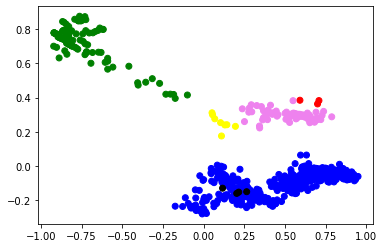

In [24]:
pca = PCA(n_components = 7)
pca_scale = pca.fit_transform(df_final.drop('site_id',axis=1))
pca_df = pd.DataFrame(pca_scale,columns=['pc'+str(i+1) for i in range(7)])

clustering = dbs(eps=0.15, min_samples=2).fit(pca_df) 
pca_df['cluster'] = clustering.labels_

c1 = pca_df[pca_df.cluster == 0]
c2 = pca_df[pca_df.cluster == 6]
c3 = pca_df[pca_df.cluster == 7]
c4 = pca_df[pca_df.cluster == 11]
c5 = pca_df[pca_df.cluster == 12]
c6 = pca_df[pca_df.cluster == 26]

df_to_plot=pca_df.loc[list(c1.index)+list(c2.index)+list(c3.index)+
                     list(c4.index)+list(c5.index)+list(c6.index),:]
x = df_to_plot.pc1
y = df_to_plot.pc2
c =['blue']*len(c1)+['red']*len(c2)+['green']*len(c3)+['black']*len(c4)+['yellow']*len(c5)+['violet']*len(c6)
plt.scatter(x,y,c=c)
plt.show()

In [29]:
from sklearn.cluster import MeanShift
pca = PCA(n_components = 7)
pca_scale = pca.fit_transform(df_final.drop('site_id',axis=1))
pca_df = pd.DataFrame(pca_scale,columns=['pc'+str(i+1) for i in range(7)])
res = []
for eps in [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,1.5]:
    for minpts in ['']: # [2,3]:
        clustering = MeanShift(bandwidth=eps).fit(pca_df)
        pca_score = silhouette_score(pca_df,clustering.labels_)
        raw_score = silhouette_score(df_final.drop('site_id',axis=1),clustering.labels_)
        res.append([eps,minpts,len(set(clustering.labels_)),len([i for i in clustering.labels_ if i == -1]),
                    pca_score,raw_score])
        
        
pd.DataFrame(res,columns=['eps','minpts','no_of_clusters','no_of_noise','pca_score','raw_score'])

,eps,minpts,no_of_clusters,no_of_noise,pca_score,raw_score
0,0.1,,545,0,0.316265,0.245316
1,0.2,,230,0,0.352981,0.313110
2,0.3,,90,0,0.292196,0.272786
3,0.4,,38,0,0.329331,0.306150
4,0.5,,18,0,0.379862,0.356469
5,0.6,,7,0,0.356030,0.328611
6,0.7,,4,0,0.411671,0.386437
7,0.8,,2,0,0.600534,0.606369
8,0.9,,2,0,0.600534,0.606369
9,1.0,,2,0,0.600534,0.606369


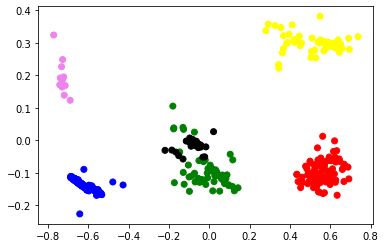

In [30]:
pca = PCA(n_components = 7)
pca_scale = pca.fit_transform(df_final.drop('site_id',axis=1))
pca_df = pd.DataFrame(pca_scale,columns=['pc'+str(i+1) for i in range(7)])

clustering = MeanShift(bandwidth=.2).fit(pca_df)
pca_df['cluster'] = clustering.labels_

c1 = pca_df[pca_df.cluster == 0]
c2 = pca_df[pca_df.cluster == 6]
c3 = pca_df[pca_df.cluster == 7]
c4 = pca_df[pca_df.cluster == 11]
c5 = pca_df[pca_df.cluster == 12]
c6 = pca_df[pca_df.cluster == 26]

df_to_plot=pca_df.loc[list(c1.index)+list(c2.index)+list(c3.index)+
                     list(c4.index)+list(c5.index)+list(c6.index),:]
x = df_to_plot.pc1
y = df_to_plot.pc2
c =['blue']*len(c1)+['red']*len(c2)+['green']*len(c3)+['black']*len(c4)+['yellow']*len(c5)+['violet']*len(c6)
plt.scatter(x,y,c=c)
plt.show()

In [41]:
pca = PCA(n_components = 7)
pca_scale = pca.fit_transform(df_final.drop('site_id',axis=1))
pca_df = pd.DataFrame(pca_scale,columns=['pc'+str(i+1) for i in range(7)])
res = []
for i in range(10,1000):
    clustering = KMeans(n_clusters=i).fit(pca_df) 
    pca_score = silhouette_score(pca_df,clustering.labels_)
    raw_score = silhouette_score(df_final.drop('site_id',axis=1),clustering.labels_)
    res.append([i,minpts,len(set(clustering.labels_)),len([i for i in clustering.labels_ if i == -1]),
                pca_score,raw_score])
    if i%100==0 :print('n_clusers :'+str(i))
        
        
res = pd.DataFrame(res,columns=['n_clusters','minpts','no_of_clusters','no_of_noise','pca_score','raw_score'])

n_clusers :100
n_clusers :200
n_clusers :300
n_clusers :400
n_clusers :500
n_clusers :600
n_clusers :700
n_clusers :800
n_clusers :900


In [48]:
res.sort_values('raw_score',ascending=False)[:25]

,n_clusters,minpts,no_of_clusters,no_of_noise,pca_score,raw_score
21,31,,31,0,0.424565,0.379035
26,36,,36,0,0.419740,0.375122
13,23,,23,0,0.409992,0.374218
12,22,,22,0,0.408717,0.368897
17,27,,27,0,0.410914,0.368544
16,26,,26,0,0.408453,0.366868
9,19,,19,0,0.404170,0.365999
11,21,,21,0,0.403779,0.365348
10,20,,20,0,0.401282,0.363357
30,40,,40,0,0.410845,0.360469


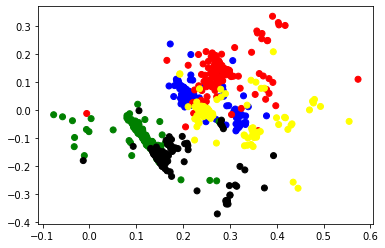

In [10]:
pca = PCA(n_components = 7)
pca_scale = pca.fit_transform(df_final.drop('site_id',axis=1))
pca_df = pd.DataFrame(pca_scale,columns=['pc'+str(i+1) for i in range(7)])

clustering = KMeans(n_clusters=31).fit(pca_df) 
pca_df['cluster'] = clustering.labels_

c1 = pca_df[pca_df.cluster == 0]
c2 = pca_df[pca_df.cluster == 7]
c3 = pca_df[pca_df.cluster == 14]
c4 = pca_df[pca_df.cluster == 21]
c5 = pca_df[pca_df.cluster == 26]
c6 = pca_df[pca_df.cluster == 31]

df_to_plot=pca_df.loc[list(c1.index)+list(c2.index)+list(c3.index)+
                     list(c4.index)+list(c5.index)+list(c6.index),:]
x = df_to_plot.pc1
y = df_to_plot.pc2
c =['blue']*len(c1)+['red']*len(c2)+['green']*len(c3)+['black']*len(c4)+['yellow']*len(c5)+['violet']*len(c6)
plt.scatter(x,y,c=c)
plt.show()